# Task 4: ANN Modeling with KERAS

Members: Lars Olav Thorbjørnsen, Stein Are Årsnes og Sanjai Vijayaratnam

### Abstract

### Introduction

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score 

In [2]:
CleanedData =pd.read_excel('CleanedFeatureSelectedFiltered.xlsx')

TargetVariable=['Vp']
Predictors=['Vs', 'DEN', 'NEU']

X=CleanedData[Predictors].values
y=CleanedData[TargetVariable].values



In [3]:
from sklearn.preprocessing import StandardScaler
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)

X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

CleanedData[TargetVariable].values
CleanedData[TargetVariable].values
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU

def create_ann_model(optimizer='adam', activation='relu'):
    model = Sequential()

    model.add(Dense(units=5, input_dim=3, kernel_initializer='normal', activation=activation))

    model.add(Dense(units=5, kernel_initializer='normal', activation=activation))

    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

model = create_ann_model(optimizer='adam', activation='relu')

model.fit(X_train, y_train ,batch_size = 32, epochs = 500, verbose=0)

history = model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=1)

test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}")

(707, 3) (707, 1)
(303, 3) (303, 1)
Epoch 1/500
23/23 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 2/500
23/23 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 3/500
23/23 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 4/500
23/23 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 5/500
23/23 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 6/500
23/23 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 0.0112
Epoch 8/500
23/23 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 9/500
23/23 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 10/500
23/23 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 11/500
23/23 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 12/500
23/23 [==============================] - 0s 2ms/step - loss: 0.0119
E

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 20        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [5]:
Predictions=model.predict(X_test)
 
# Scaling the predicted data back to original scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
 
# Scaling the y_test data back to original scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

####y_test_orig=y_test

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

#####Test_Data=X_test
#=============================================================

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Range']=y_test_orig
TestingData['Predicted Range']=Predictions
TestingData.head(20)

10/10 [==============================] - 0s 2ms/step


,Vs,DEN,NEU,Range,Predicted Range
0,2.155100,2.448373,0.193060,4.025490,4.027634
1,1.955262,2.505220,0.161473,3.999882,3.917499
2,2.086879,2.476793,0.173620,4.011978,3.991383
3,2.248506,2.450553,0.186740,4.161339,4.148489
4,2.157967,2.424053,0.208233,4.020045,3.991307
5,2.152907,2.468073,0.185593,4.098045,4.059107
6,2.164396,2.430067,0.212853,4.012111,4.012663
7,2.154976,2.428647,0.208860,4.014356,3.996404
8,2.122026,2.362633,0.219727,3.772330,3.787037
9,1.843511,2.248420,0.300713,3.331263,3.322005


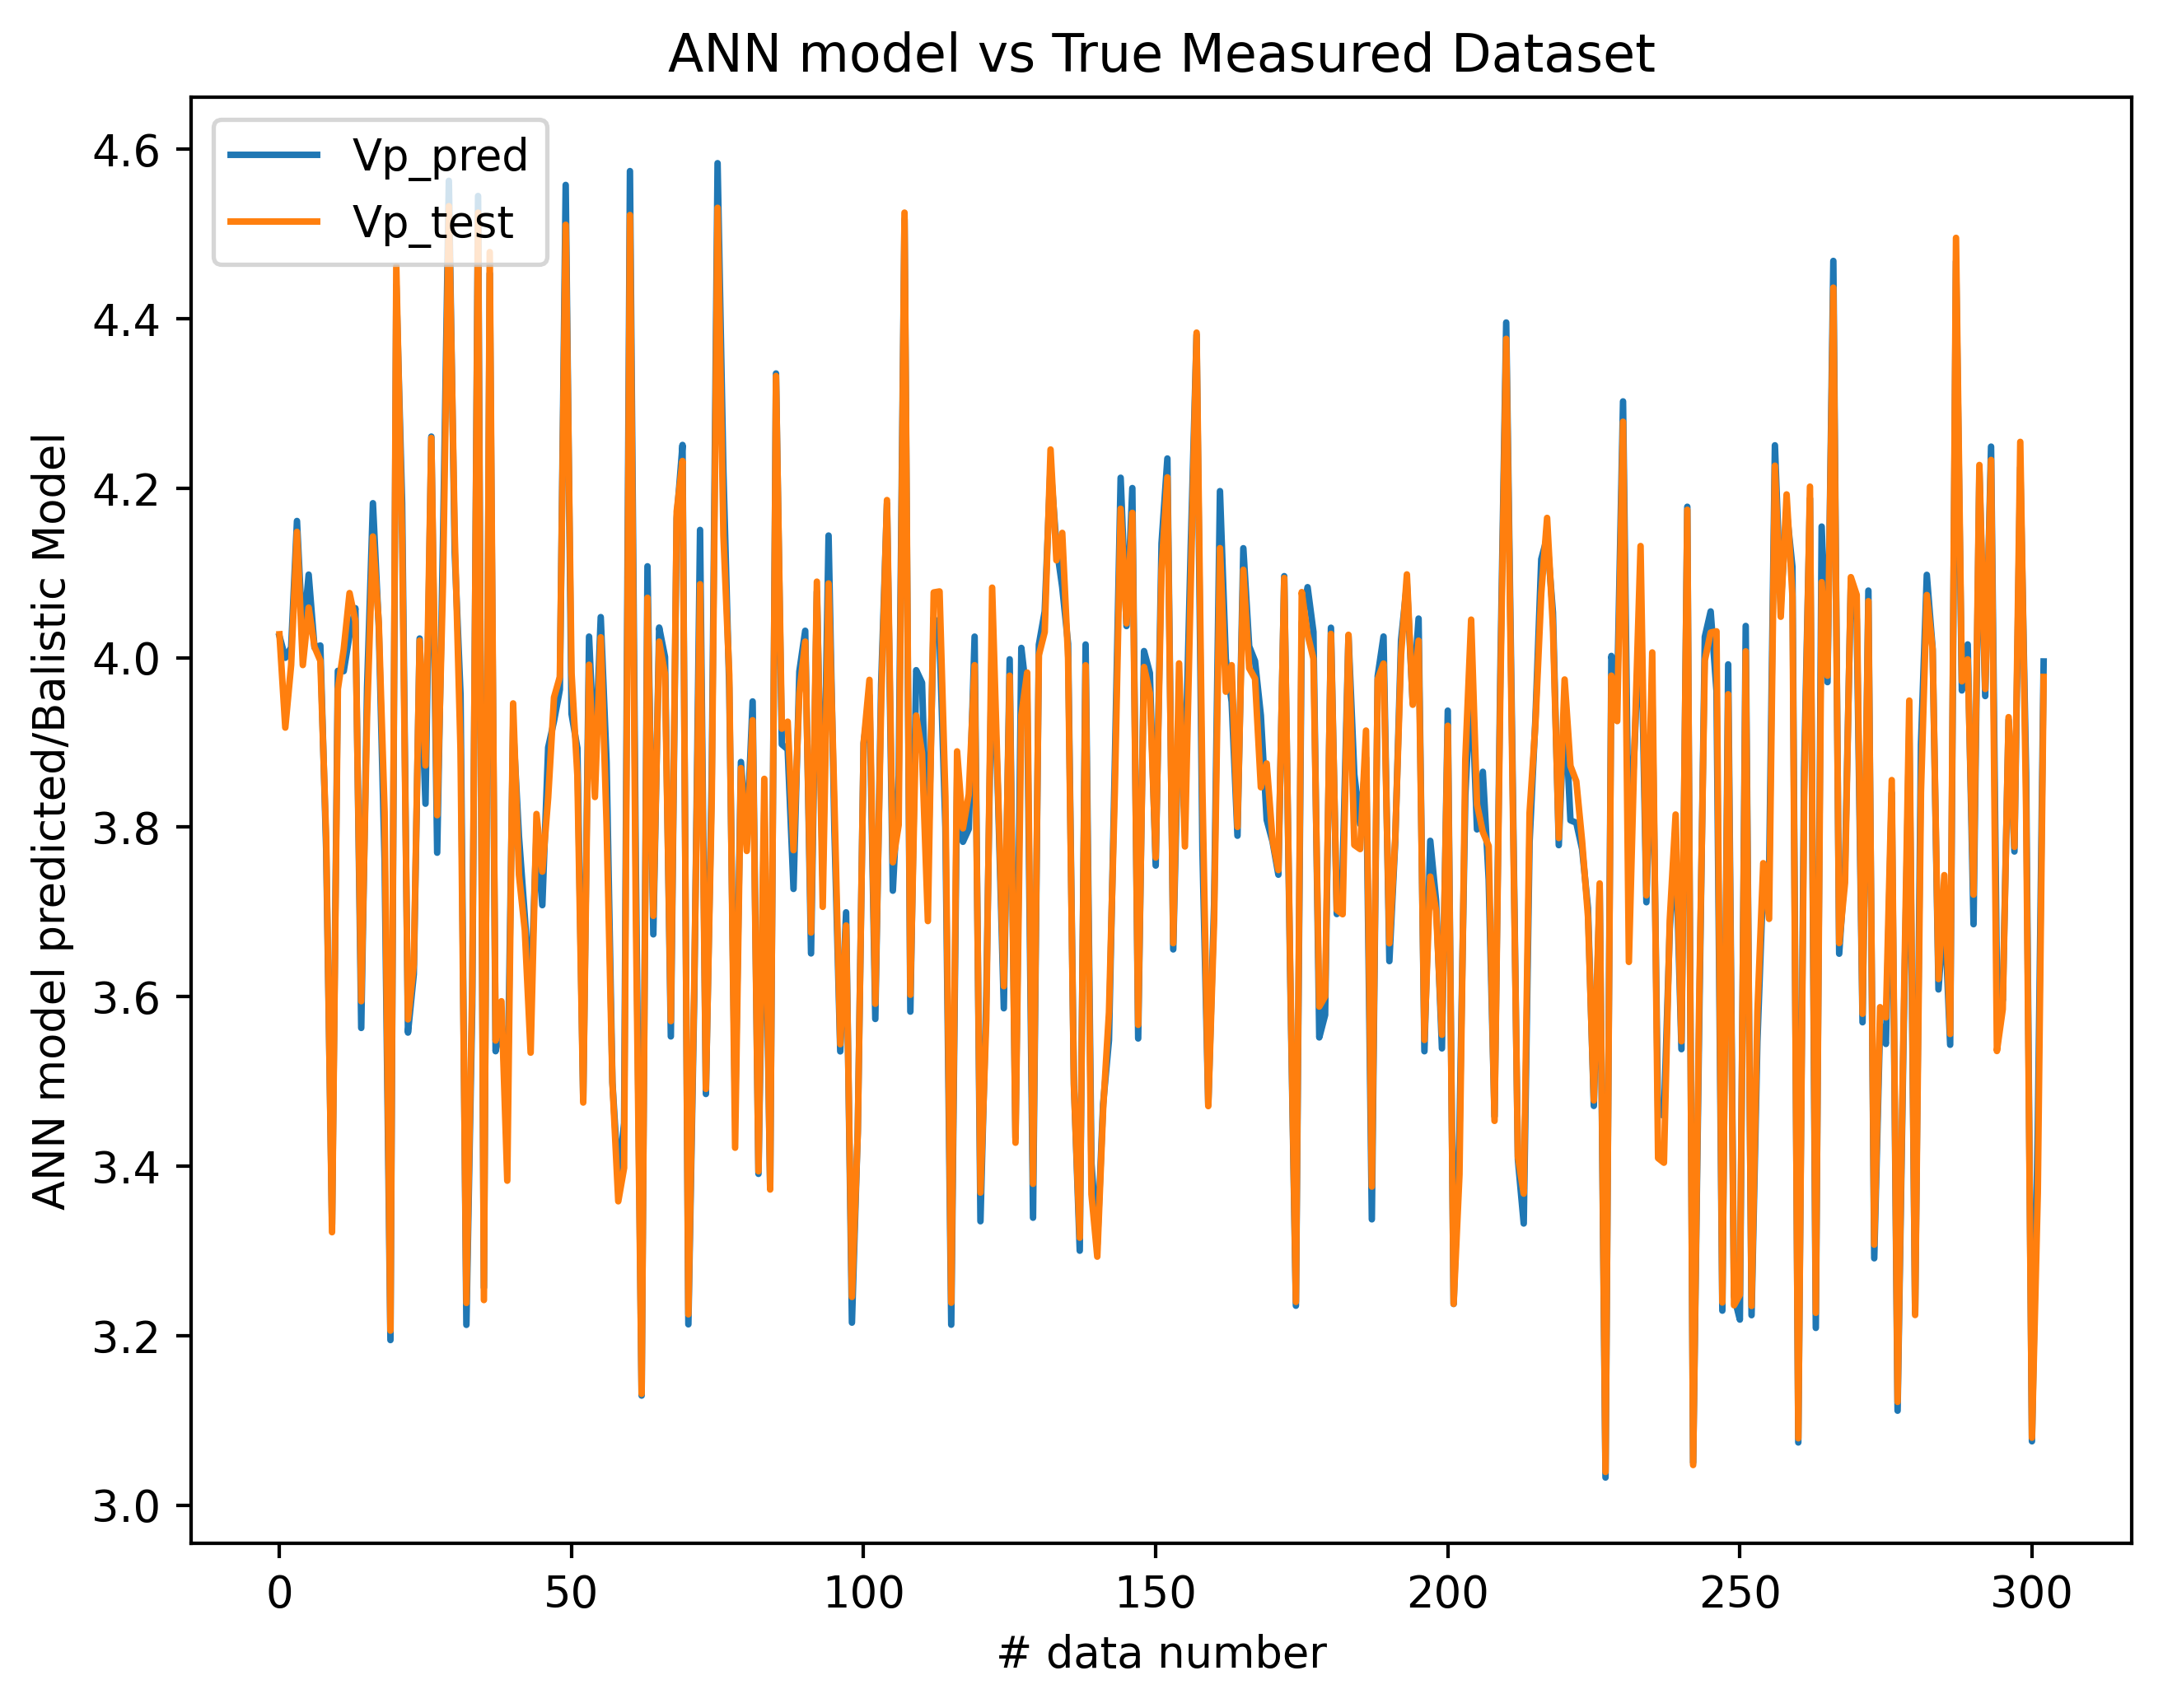

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=380)

plt.plot(y_test_orig)
plt.plot(Predictions)


plt.title('ANN model vs True Measured Dataset')
plt.ylabel('ANN model predicted/Balistic Model')
plt.xlabel('# data number')
plt.legend(['Vp_pred', 'Vp_test'], loc='upper left')
plt.show()

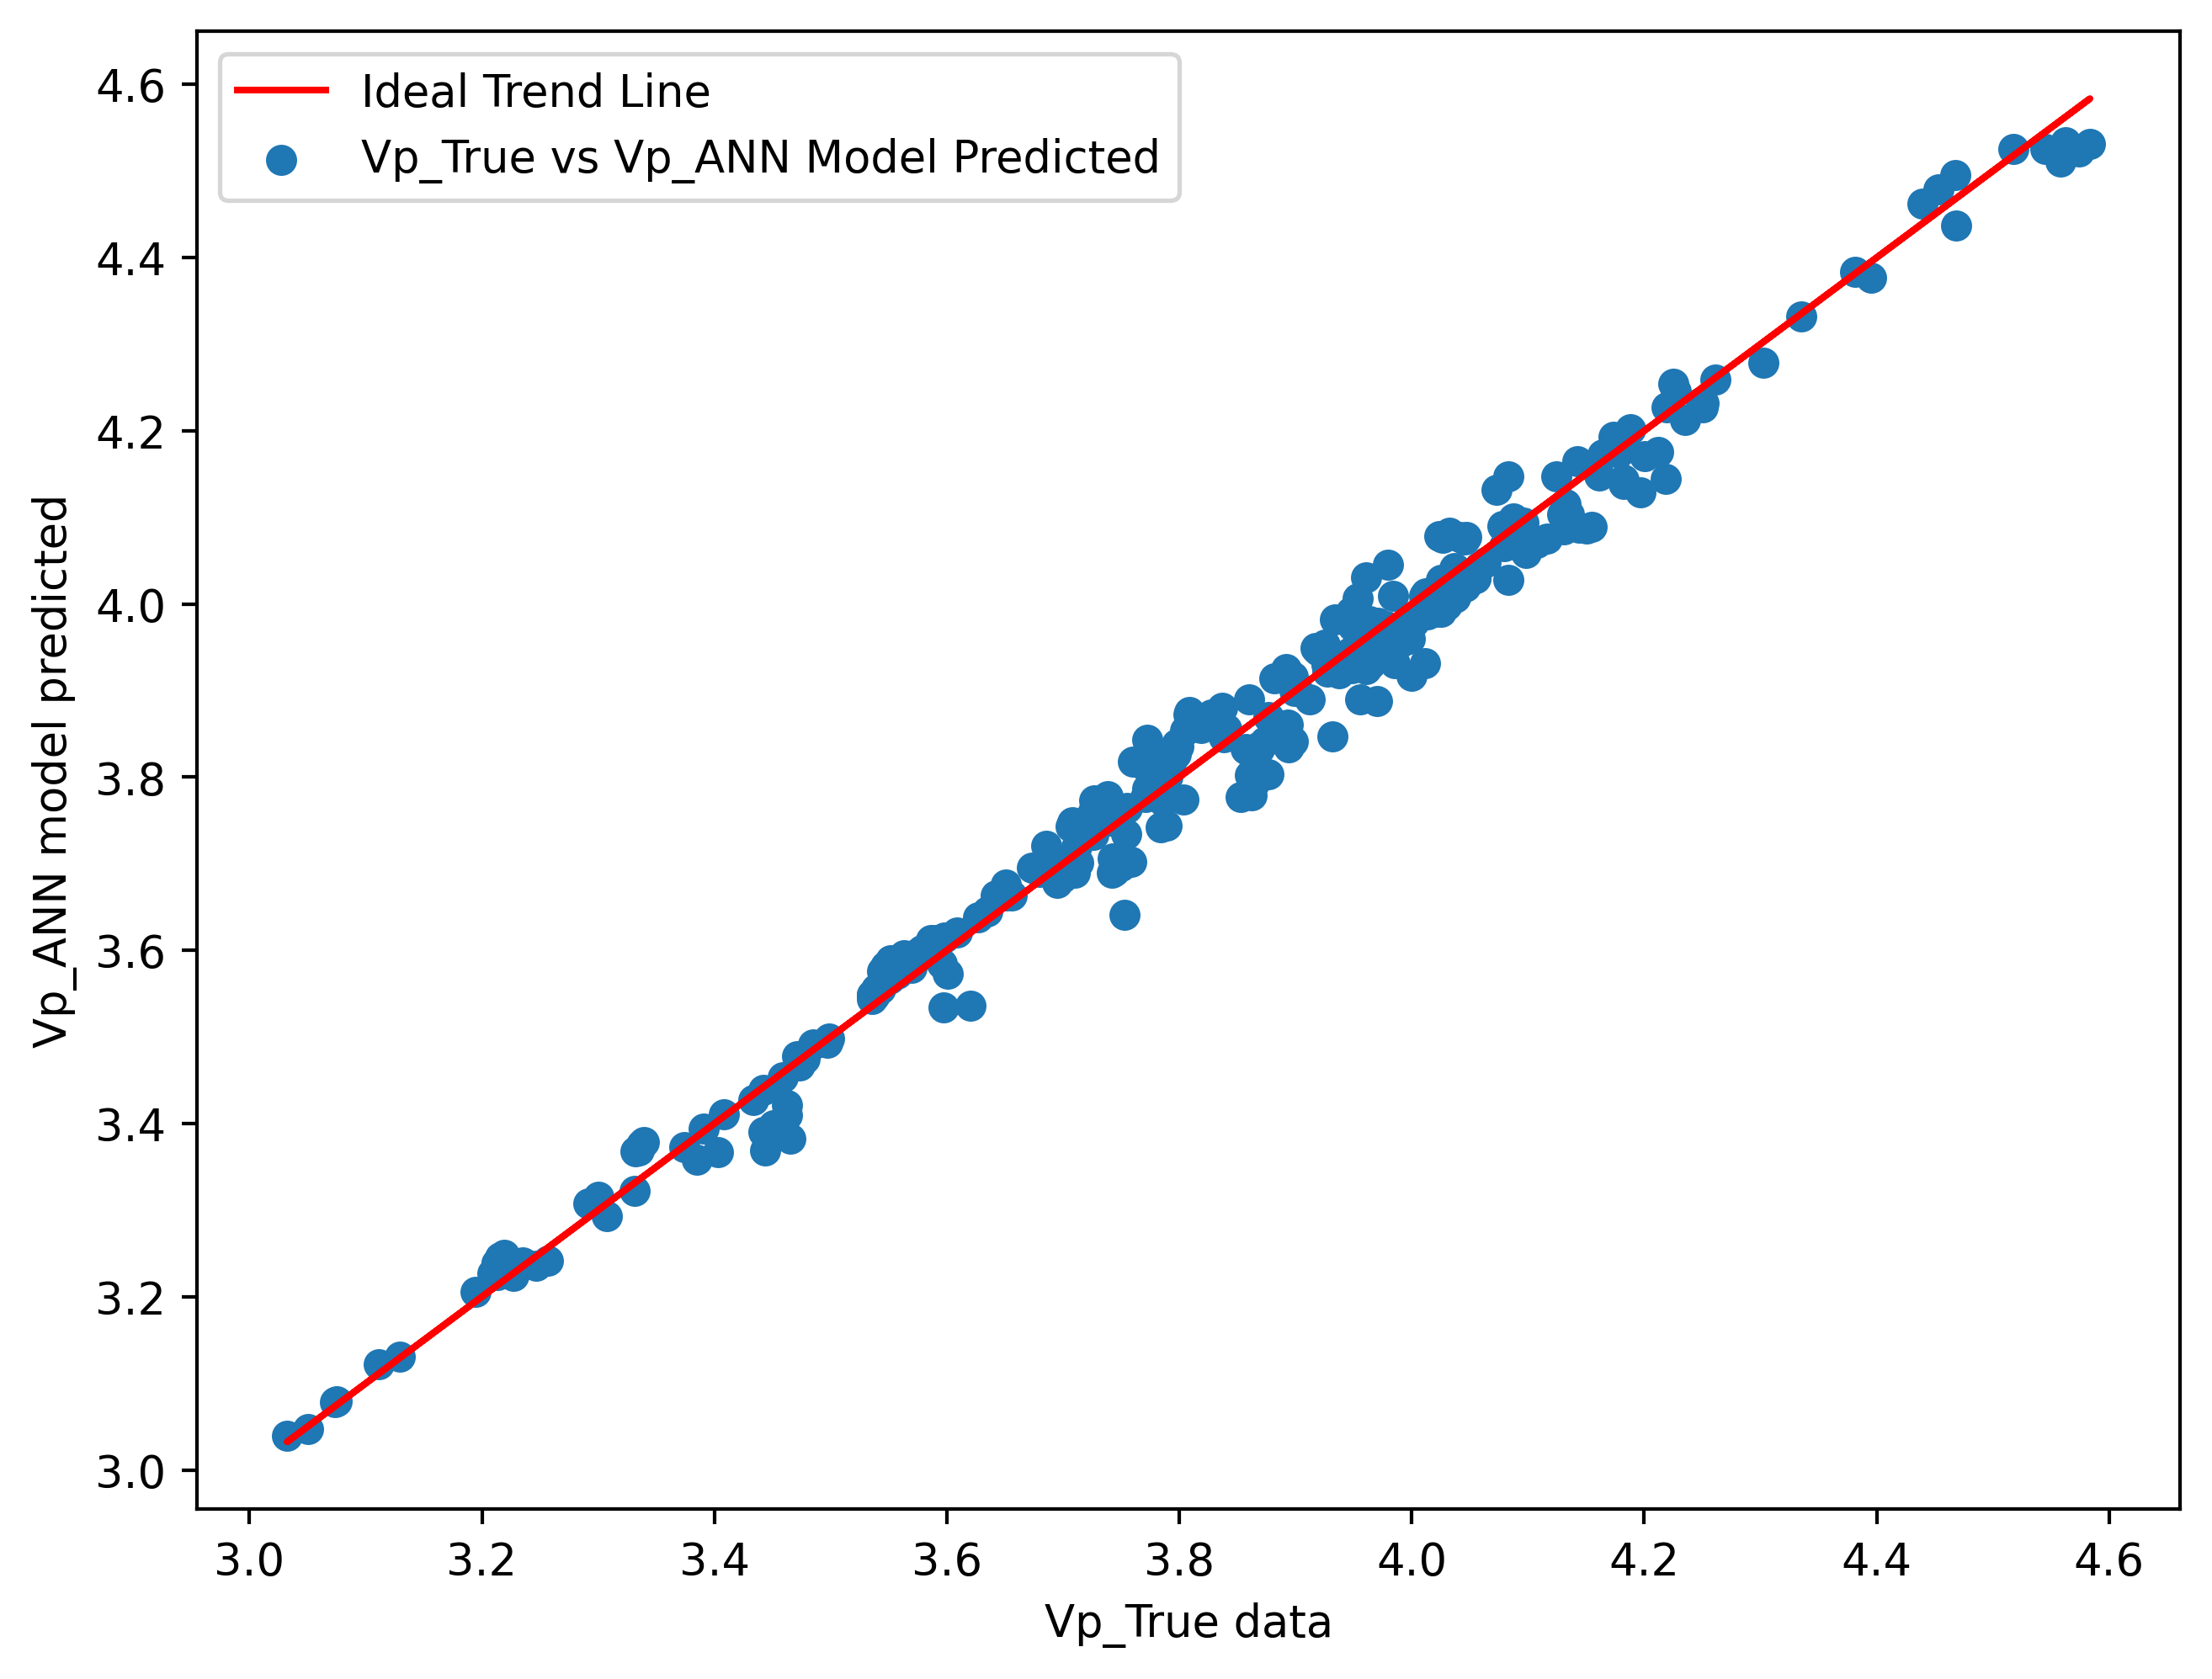

In [7]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=380)

plt.plot(y_test_orig,y_test_orig, 'r')
plt.scatter(y_test_orig, Predictions)

plt.ylabel('Vp_ANN model predicted')
plt.xlabel('Vp_True data')
plt.legend(['Ideal Trend Line','Vp_True vs Vp_ANN Model Predicted'], loc='upper left')

#plt.ylim(2.7, 4.75)
#plt.xlim(2.7, 4.75)

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Transformed dataset
mse_no= mean_squared_error(y_test,model.predict(X_test))
r2_no= r2_score(y_test,model.predict(X_test))

# Original dataset after inversion back
#mse_no= mean_squared_error(y_test_orig,Predictions)
#r2_no= r2_score(y_test_orig,Predictions)

10/10 [==============================] - 0s 2ms/step


In [9]:
print('Mean Square Error       :',mse_no)
print('R2 Score                :',r2_no)


Mean Square Error       : 0.01185265946034104
R2 Score                : 0.9882126597485187


In [10]:
# list all data in history
print(history.history.keys())

dict_keys(['loss'])


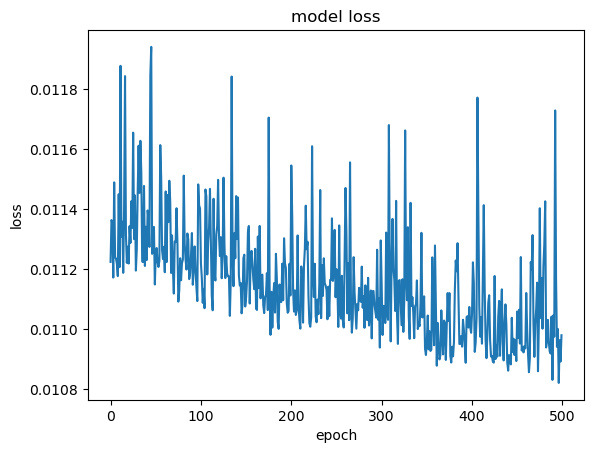

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['test'], loc='upper right')
#plt.ylim(0, 0.001)
#plt.xlim(0, 1000)
plt.show()

### Reflections

### Conclusion

### References